# Cell type assignment

In this notebook, we analyse the cell type predictions of the automated annotation model and validate its cell type assignments using marker gene expression and other sources of information (e.g. knowledge of developmental stages and anatomical dissections).  

In [170]:
import scrabbitpy
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import math

seed = 42
sc.set_figure_params(dpi=150,dpi_save=300)


### Load data

In [2]:
# Load data
r_data = sc.read_h5ad("../data-in/cell_type_annotation/rabbit_corrected_clustered.h5ad")
orthologs = pd.read_csv("../data-in/orthologs/rabbit_mouse_orthologs.tsv", sep="\t")


In [3]:
# TODO make gene names default var.index for r_data
r_genes = pd.read_csv("../data-in/raw/genes.tsv", sep="\t")
r_data.var.index = r_genes["gene_name"]


In [31]:
# TODO add this as default for r_data
# Add anatomical location info
r_data.obs["anatomical_loc"] = "Whole embryo"
r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([12,16])] = "Head"
r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([13,17])] = "Trunk"
r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([14,18])] = "Tail"
r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([15,19,22,26])] = "Yolk sac"
r_data.obs["anatomical_loc"] = r_data.obs["anatomical_loc"].astype("category")


anatomy_colours = {
    "Head":"red",
    "Trunk": "blue",
    "Tail": "green",
    "Yolk sac": "orange",
    "Whole embryo": "grey"
}
r_data.uns["anatomical_loc_colors"] = [anatomy_colours[x] for x in r_data.obs["anatomical_loc"].cat.categories]

<ipython-input-31-2557cd04a932>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([12,16])] = "Head"
<ipython-input-31-2557cd04a932>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_data.obs["anatomical_loc"][r_data.obs["sample"].isin([13,17])] = "Trunk"
<ipython-input-31-2557cd04a932>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_data.obs["anatomical_loc"][r_data.obs["sample

In [4]:
m_markers = pd.read_csv("../data-in/cell_type_annotation/celltype_markers.tsv", sep="\t")
m_markers = {i: m_markers[i].dropna().to_list() for i in m_markers.columns}


In [5]:
orthologs_copy = orthologs
orthologs_copy.index = orthologs_copy["mouse_gene_name"]
r_markers = {i: list(orthologs_copy.loc[[x for x in m_markers[i] if x in orthologs_copy["mouse_gene_name"]] ,"rabbit_gene_name"]) for i in list(m_markers.keys())  }


### Cluster data

Cell type labels are assigned to clusters identified in the high-dimensional gene expression space. Here we perfrom Leiden clustering at various resolutions to identify both coarse and fine-grained populations of cells.

For the sake of brevity, here we have used precomputed clusterings. See `scripts/cluster.py` to run the full clustering.  

In [ ]:
# Load clusters from file
clusters = pd.read_csv("../data-in/cell_type_annotation/clusters.tsv",sep="\t")
r_data.obs = r_data.obs.join(clusters)


### Divide dataset

To simplify the annotation process, the dataset is initially divded into broad regions to be annotated separately. 

For each broad region, we plot the automated annotation predictions, along with clusterings of different resolutions. In addition to clustering the entire dataset, Leiden clustering is also performed within each region. These results are compared to UMAP plots of marker gene expression of known cell types as well as differentially expressed genes computationally identified in the annotated mouse dataset.



In [ ]:
blood = r_data[r_data.obs["leiden_res1"].isin(['4','19','20','8']),]
r_mesoderm = r_data[r_data.obs["leiden_res1"].isin(['17','2','12','22']),]
neural = r_data[r_data.obs["leiden_res1"].isin(['3','7']),]
misc = rabbit[r_data.obs["leiden_res1"].isin(['6','23','21','18']),]
exe_ectoderm = r_data[r_data.obs["leiden_res1"].isin(['9','0','16']),]
exe_mesoderm = r_data[r_data.obs["leiden_res1"].isin(['5','14','10','1','22']),]
exe_endoderm = r_data[r_data.obs["leiden_res1"].isin(['13','15','11']),]



### Useful plots



It can also be informative to plot the fraction of cells predicted as each cell type within each cluster. Since the annotation model makes predictions independently for each cell, if there are clusters of cells with a common cell type prediction, it may be suggestive of a reliable annotation. Similarly, we can plot the distribution across clusters for each predicted cell type label. 

<AxesSubplot:title={'center':'anatomical_loc'}, xlabel='UMAP1', ylabel='UMAP2'>

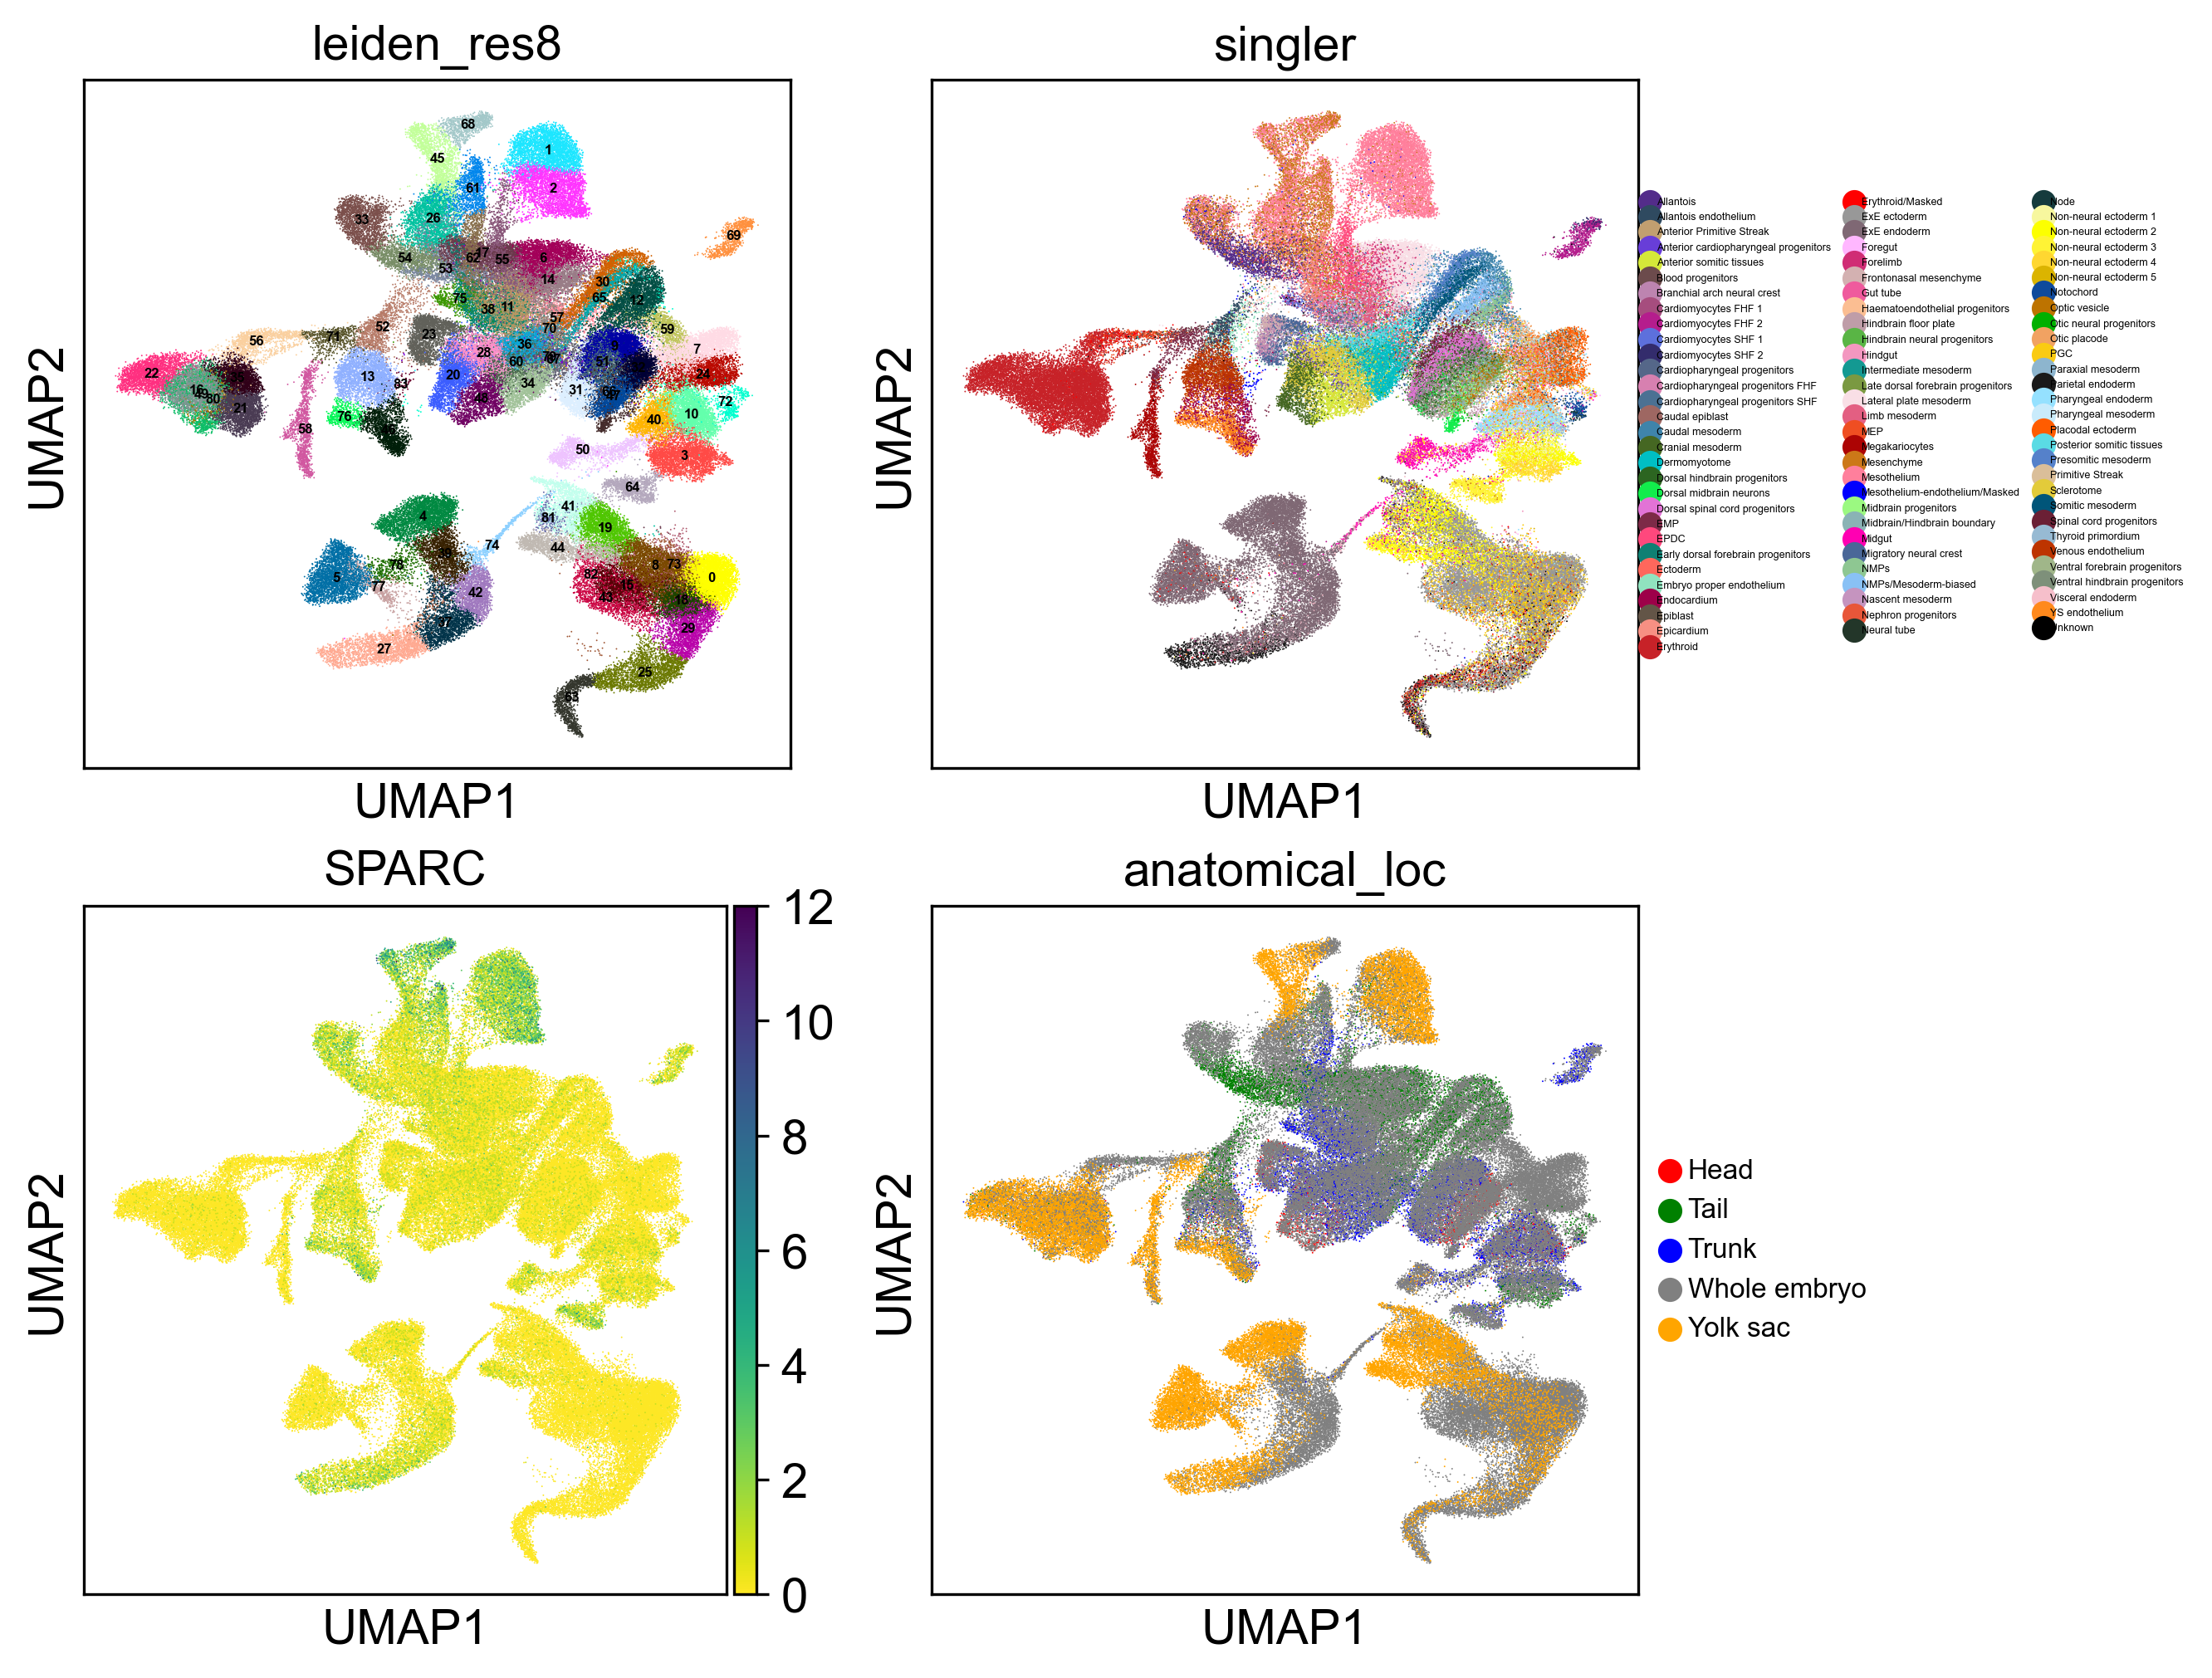

In [180]:
fig, axs = plt.subplots(2, 2,figsize=(8,8))

sc.pl.umap(r_data,color=["leiden_res8"],legend_loc="on data",legend_fontsize=4,ax=axs[0,0],show=False)
sc.pl.umap(r_data,color=["singler"],legend_fontsize=3,ax=axs[0,1],show=False,legend_fontweight="normal")
sc.pl.umap(r_data,color=r_markers["Yolk sac endothelium"][1],color_map="viridis_r",ax=axs[1,0],show=False)
sc.pl.umap(r_data,color=["anatomical_loc"],legend_fontsize=8,ax=axs[1,1],show=False)


#frac_plot = plotObsFraction(r_data,"")

<AxesSubplot:title={'center':'singler: YS endothelium (1463 cells)'}, xlabel='Fraction of cells', ylabel='leiden_res8'>

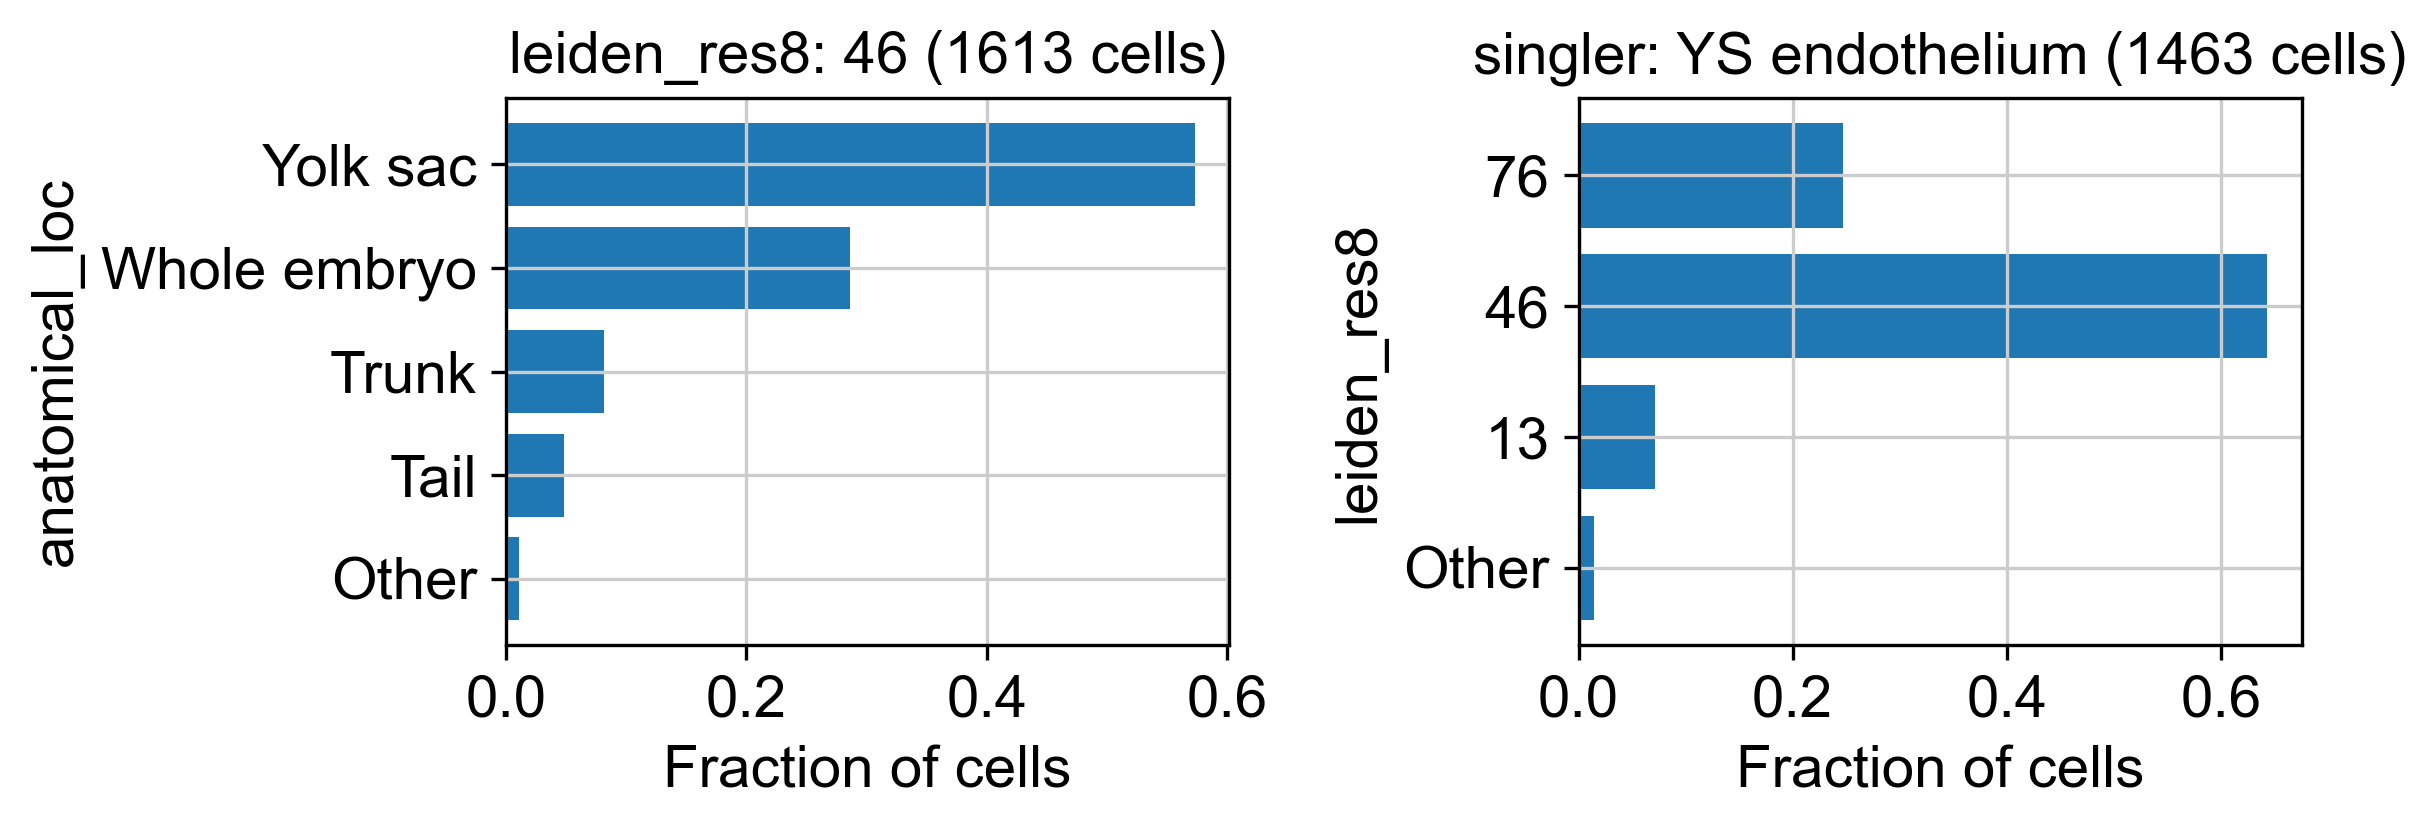

In [182]:
fig, axs = plt.subplots(1, 2,figsize=(8,3))

plotObsFraction(r_data,obA="46", obsA = "leiden_res8", obsB = "anatomical_loc", 
                     obsA_ignore_thresh = 50 , obsB_ignore_thresh = 0.02,ax=axs[0])
                     #colours = scrabbit.getCelltypeColours())
    
plotObsFraction(r_data,obA="YS endothelium", obsA = "singler", obsB = "leiden_res8", 
                     obsA_ignore_thresh = 50 , obsB_ignore_thresh = 0.02,ax=axs[1])

### Make annotation plots 

We can produce the figures above for each broad region, and for each clustering  

In [231]:
def createAnnotationDirs(base_path, clusters):
    """
    
    e.g.
    createAnnotationDirs(base_path = "../figs/celltype_annotation/annotation_pipeline/r_mesoderm/", 
                     clusters = ["leiden_res8","mesoderm_leiden_res2","mesoderm_leiden_res5"])
                     
    """
    
    # Marker expression plots
    Path(base_path + "marker_expression").mkdir(parents=True, exist_ok=True)
    
    # Cluster fraction plots
    Path(base_path + "cluster_fractions").mkdir(parents=True, exist_ok=True)
    
    # Prediction fraction plots
    Path(base_path + "prediction_fractions").mkdir(parents=True, exist_ok=True)
    
    for cluster in clusters:
        # Create directory for each clustering
        Path(base_path + "cluster_fractions/" + cluster).mkdir(parents=True, exist_ok=True)
        Path(base_path + "prediction_fractions/" + cluster).mkdir(parents=True, exist_ok=True)
        
    

In [ ]:
def plotMarkerExpression(adata, markers,):
    """
    adata: Scanpy object
    markers: Dictionary where keys are the cell types/obs groups of interest and items are marker gene names which match values in adata.var.index.   
    """
    
    

In [110]:
def computeObsFraction(adata, obsA="leiden_res8",obsB="singler", obsB_ignore_thresh = None ):
    """
    Computes the fraction of observations B within groups of observation A.
    
    """
    
    df = pd.DataFrame({obsA:adata.obs[obsA], obsB:adata.obs[obsB]},index=adata.obs.index)
    df[obsA + "_ncells"] = df.groupby([obsA]).transform('count')

    df[obsB + "_count"] = 0

    counts = df.groupby([obsA,obsB,obsA + "_ncells"]).count()
    counts[obsB + "_frac"] = counts[obsB + "_count"].groupby(obsA).transform(lambda x: x/x.sum())
    counts.sort_values([obsA,obsB,obsB + "_frac"],ascending=False)
    
    counts= counts.reset_index()
    counts = counts.dropna()
    
     # Group observations B with very few cells as 'Other'
    if(obsB_ignore_thresh is not None) :
        counts[obsB] = counts[obsB].astype(str)
        counts.loc[counts[obsB + "_frac"] <= obsB_ignore_thresh,obsB] = "Other"      
        
    
    
    return(counts)

In [227]:
data = computeObsFraction(r_mesoderm, obsA = "leiden_res8", obsB = "singler", obsB_ignore_thresh = 0.05)
data

leiden_res8                 singler  leiden_res8_ncells  singler_count  \
1066            3   Non-neural ectoderm 4                   1            1.0   
1931            6         Caudal mesoderm                  37           19.0   
2243            6                   Other                  37            1.0   
2425            6  Lateral plate mesoderm                  37            8.0   
3023            6     Presomitic mesoderm                  37            9.0   
...           ...                     ...                 ...            ...   
47306          79              Sclerotome                 294           25.0   
47332          79                   Other                 294            5.0   
47358          79                   Other                 294            9.0   
47410          79                   Other                 294            1.0   
47436          79                   Other                 294            8.0   

       singler_frac  
1066       1.000000  
1931       0.513514  
2243       0.027027  
2425       0.216216  
3023       0.243243  
...             ...  
47306      0.085034  
47332      0.017007  
47358      0.030612  
47410      0.003401  
47436      0.027211  

[448 rows x 5 columns]

In [134]:
def plotObsFraction(data, obA, obsA, obsB, obsA_ignore_thresh = None, obsB_ignore_thresh = None, export_dir=None, obsB_colours=None,ax=None,
                   figsize=(10,10)):
    """
    obA: A specific value of obsA
    
    """
    
    # Get obs fractions if anndata object passed in
    if(isinstance(data,sc.AnnData)):
        data = computeObsFraction(data, obsA = obsA, obsB = obsB, obsB_ignore_thresh = obsB_ignore_thresh)
    
    # Don't plot fractions for observations with very few cells
    if(obsA_ignore_thresh is not None):
        data = data.loc[data[obsA + "_ncells"] >= obsA_ignore_thresh]
        
    df_plot = data[data[obsA]==obA]
    
    if(obsB_colours is not None):
                obsB_colours = [obsB_colours[i] for i in df_plot[obsB]]
                
    #fig, ax = plt.subplots(figsize=figsize)
    
    ax.barh(df_plot[obsB], df_plot[obsB + "_frac"], color=obsB_colours)
            
    ax.set_title(obsA + ": " +  obA + " (" + str(int(df_plot[obsA + "_ncells"].iloc[0]))+ " cells)")
    ax.set_xlabel("Fraction of cells")
    ax.set_ylabel(obsB)
            
    plt.tight_layout()
    #plt.show()
    
    return(ax)
            
    #plt.savefig(export_dir + obA + ".pdf")
    #plt.close(fig)
    

In [108]:
def plotMultiObsFraction(data, obsA, obsB, obsA_ignore_thresh = None, obsB_ignore_thresh = None, export_dir=None, obsB_colours=None):
    
    """
    
    e.g. 
    plotMultiObsFraction(r_mesoderm, obsA = "leiden_res8", obsB = "singler", 
                     obsA_ignore_thresh = 50 , obsB_ignore_thresh = 0.02,
                     #colours = scrabbit.getCelltypeColours(),
                     export_dir = "../figs/celltype_annotation/annotation_pipeline/r_mesoderm/cluster_fractions/leiden_res8/")
                     
    """
    # Get obs fractions if anndata object passed in
    if(isinstance(data,sc.AnnData)):
        data = computeObsFraction(data, obsA = obsA, obsB = obsB, obsB_ignore_thresh = obsB_ignore_thresh)
    
    # Don't plot fractions for observations with very few cells
    if(obsA_ignore_thresh is not None):
        data = data.loc[data[obsA + "_ncells"] >= obsA_ignore_thresh]
    
    
    # if(export_dir is None):
        # Plot in a grid
    
    
    if(export_dir is not None):
        for x in data[obsA].unique():
            fig, ax = plt.subplots(figsize=(10,10))
            
            df_plot = data[data[obsA]==x]
            
            if(obsB_colours is not None):
                obsB_colours = [obsB_colours[i] for i in df_plot[obsB]]
                
            ax.barh(df_plot[obsB], df_plot[obsB + "_frac"], color=obsB_colours)
            
            ax.set_title(obsA + ": " +  x + " (" + str(int(df_plot[obsA + "_ncells"].iloc[0]))+ " cells)")
            ax.set_xlabel("Fraction of cells")
            ax.set_ylabel(obsB)
            
            plt.tight_layout()
            
            # Replace / in obs names to avoid directory confusion
            x = x.replace('/', '_')
            
            plt.savefig(export_dir + x + ".pdf")
            plt.close(fig)

In [ ]:
def makeAnnotationPlots(adata, clusters, model_predictions, markers, other_obs=None, export_dir= "", 
                        obsA_ignore_thresh = 50, obsB_ignore_thresh = 0.02):
    
    
    createAnnotationDirs(base_path = export_dir, clusters = clusters )
    
    
    # Plot UMAPs of SingleR predictions, Clusterings
    sc.settings.figdir = export_dir
    sc.pl.umap(adata, color=[model_predictions]+ other_obs + clusters,
               legend_loc="on data", legend_fontsize=4,
               save="_clusters.pdf",show=False)
    

    # Plot UMAPs of literature marker genes
    sc.settings.figdir = export_dir + "marker_expression/"
    for celltype in list(markers.keys()):
        sc.pl.umap(adata,color=markers[celltype],color_map="viridis_r",
                   save="_" + celltype.replace('/', '_') + "_markers.pdf",show=False)
    
    
    for cluster in clusters:
        
        # Plot bar charts of cluster prediction fractions
        plotMultiObsFraction(r_mesoderm, obsA = cluster, obsB = model_predictions, 
                     obsA_ignore_thresh = 50 , obsB_ignore_thresh = 0.02,
                     #colours = scrabbit.getCelltypeColours(),
                     export_dir = export_dir + "cluster_fractions/" + cluster + "/")
        
        # Plot bar charts of prediction cluster fractions
        plotMultiObsFraction(r_mesoderm, obsA = model_predictions, obsB = cluster, 
                     obsA_ignore_thresh = 50 , obsB_ignore_thresh = 0.02,
                     #colours = scrabbit.getCelltypeColours(),
                     export_dir = export_dir + "prediction_fractions/" + cluster + "/")
        



### Whole dataset

FileNotFoundError: [Errno 2] No such file or directory: '..\\figs\\celltype_annotation\\annotation_pipeline\\whole_dataset\\marker_expression\\umap_Midbrain\\hindbrain boundary_markers.pdf'

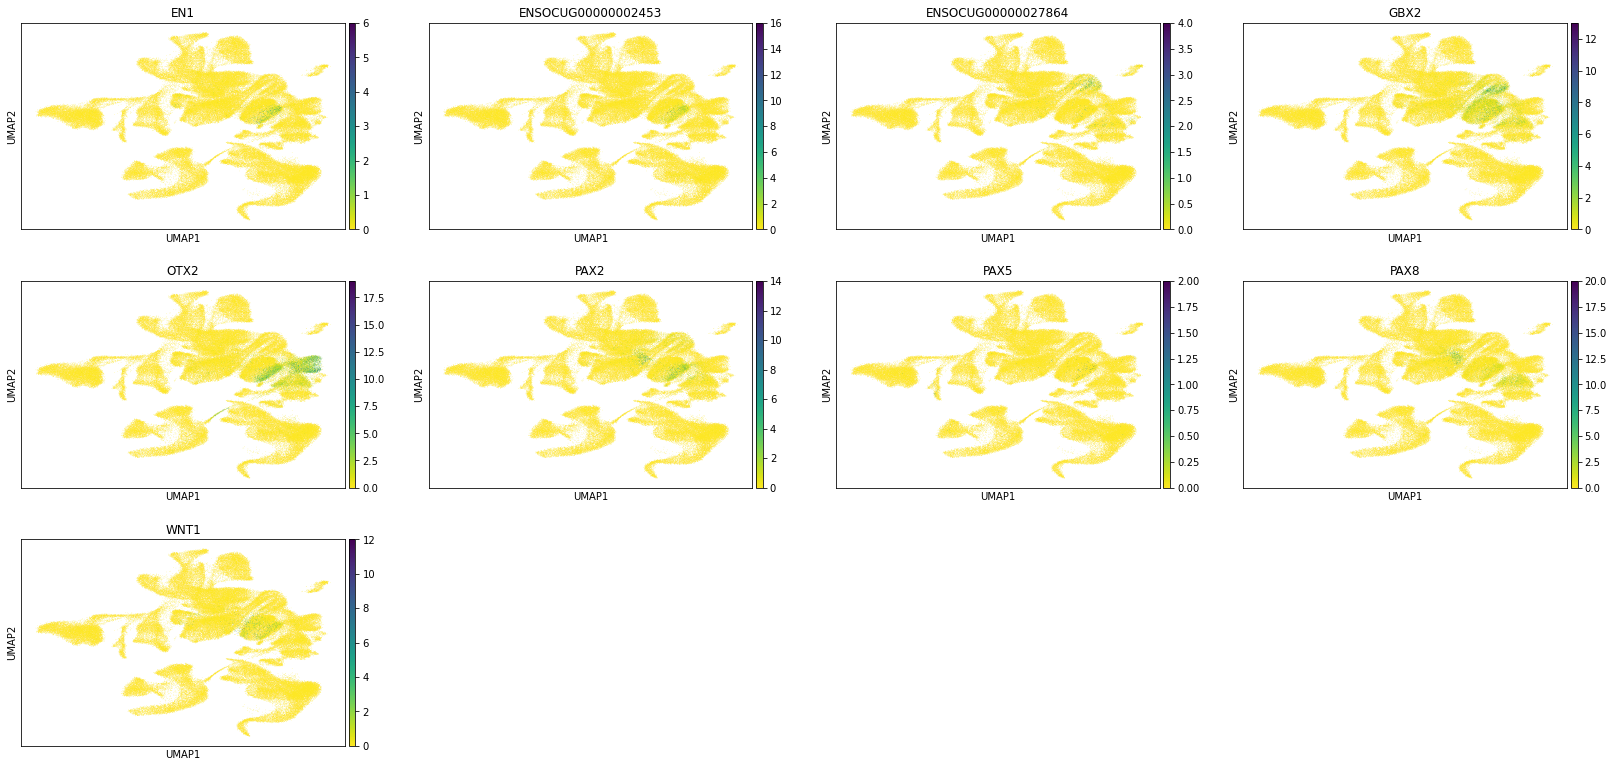

In [375]:
Path("../figs/celltype_annotation/annotation_pipeline/whole_dataset/").mkdir(parents=True, exist_ok=True)
makeAnnotationPlots(r_data, 
                    clusters = ["leiden_res8"],
                    model_predictions = "singler",
                   markers = r_markers,
                    other_obs = ["stage","anatomical_dissection"],
                   export_dir = "../figs/celltype_annotation/annotation_pipeline/whole_dataset/")

### Mesoderm

In [372]:
# Create directory for mesoderm region
Path("../figs/celltype_annotation/annotation_pipeline/r_mesoderm/").mkdir(parents=True, exist_ok=True)

# Filter out cell types unlikely to be in mesodermal region
mesoderm_celltypes = ["Anterior cardiopharyngeal progenitors","Anterior somitic tissues","Branchial arch neural crest",
                     "Cardiomyocytes FHF 1", "Cardiomyocytes FHF 2", "Cardiomyocytes SHF 1","Cardiomyocytes SHF 2",
                     "Cardiopharyngeal progenitors", 'Cardiopharyngeal progenitors SHF','Cranial mesoderm',
                     "Dermomyotome","ExE mesoderm","Frontonasal mesenchyme","Kidney",'Lateral plate mesoderm','Limb mesoderm',
                     "Migratory neural crest","Myocardium",'Nephron progenitors','Posterior somitic tissues','Sclerotome']


makeAnnotationPlots(r_mesoderm, 
                    clusters = ["leiden_res8"],
                    model_predictions = "singler",
                   markers = {k: r_markers[k] for k in mesoderm_celltypes},
                   export_dir = "../figs/celltype_annotation/annotation_pipeline/r_mesoderm/")

## Assign cell types